In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
# from sklearn.pipeline import Pipeline

#### Q4: Decision Tree and Random Forest – 15 Marks #####
Load the IRIS dataset. The dataset consists of 150 samples of iris flowers, each belonging to
one of three species (setosa, versicolor, or virginica). Each sample includes four features: sepal
length, sepal width, petal length, and petal width.

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

feature_names = iris.feature_names

iris_df = pd.DataFrame(data=iris.data, columns=feature_names)
iris_df['target'] = iris.target

target_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

iris_df['species'] = iris_df['target'].map(target_names)

display(iris_df.head(2))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa


1. Visualize the distribution of each feature and the class distribution.

In [3]:
for feature in feature_names:
    break
    plt.figure(figsize=(10, 6))
    for species in iris.target_names:
        species_data = iris_df[iris_df['species'] == species]
        plt.plot(species_data.index,
                species_data[feature],
                label=species)

    plt.xlabel('row number')
    plt.ylabel(feature)
    plt.title(f'{feature} by Species')
    plt.legend()
    plt.grid(True)
    plt.show()

2. Encode the categorical target variable (species) into numerical values.  

In [4]:
from sklearn.preprocessing import LabelEncoder

iris_df.drop(columns=["target"],inplace=True)

iris_df["Label_Encoded"] = LabelEncoder().fit_transform(iris_df["species"])
display(iris_df.head().T)

,0,1,2,3,4
sepal length (cm),5.1,4.9,4.7,4.6,5.0
sepal width (cm),3.5,3.0,3.2,3.1,3.6
petal length (cm),1.4,1.4,1.3,1.5,1.4
petal width (cm),0.2,0.2,0.2,0.2,0.2
species,setosa,setosa,setosa,setosa,setosa
Label_Encoded,0,0,0,0,0


3. Split the dataset into training and testing sets (use an appropriate ratio).  

In [31]:
target_df = iris_df["Label_Encoded"]
features_df = iris_df[feature_names]

scaler = StandardScaler()
features_df = pd.DataFrame(scaler.fit_transform(features_df), columns=feature_names,
                               index=features_df.index)


X_train, X_test, y_train, y_test = train_test_split(
    features_df, target_df,
    test_size=0.20, random_state=42,
    stratify=target_df,shuffle=True)

print(y_train.value_counts())
print(y_test.value_counts())

Label_Encoded
0    40
2    40
1    40
Name: count, dtype: int64
Label_Encoded
0    10
2    10
1    10
Name: count, dtype: int64


4. Decision Tree Model 
    1. Build a decision tree classifier using the training set. 
    2. Visualize the resulting decision tree. 
    3. Make predictions on the testing set and evaluate the model's performance using appropriate metrics (e.g., accuracy, confusion matrix).  

In [32]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


In [33]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

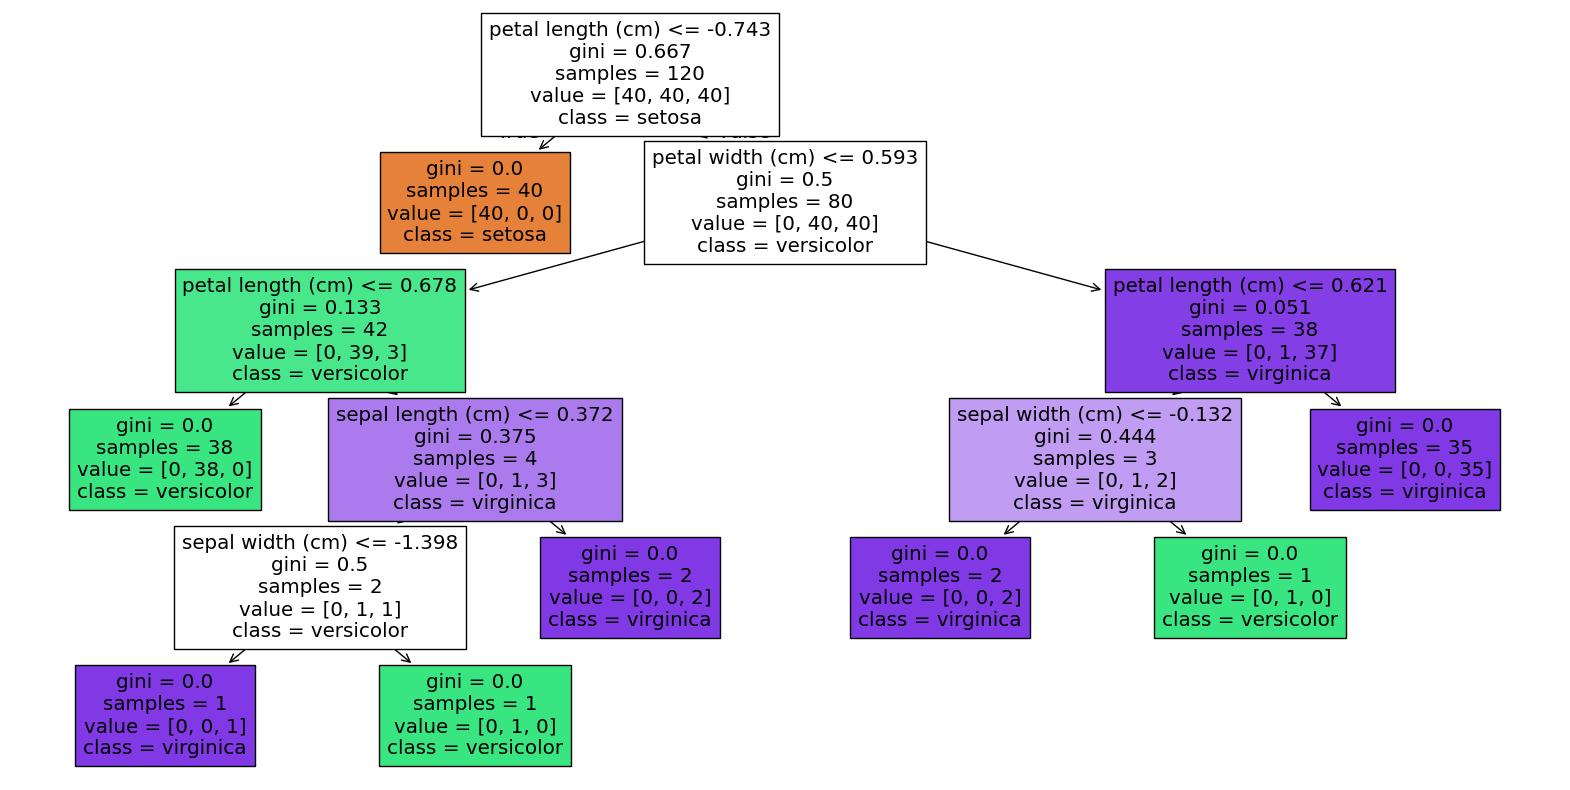

In [41]:
# %%script false --no-raise-error

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=feature_names, class_names=iris.target_names, filled=True)
plt.show()


Accuracy: 0.93


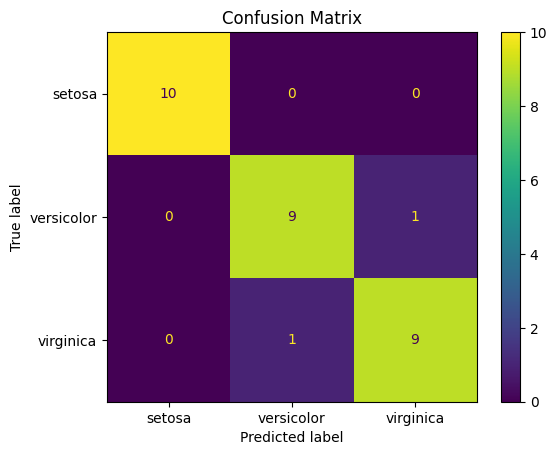


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [42]:
# %%script false --no-raise-error



accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))


5. Random Forest Model 

    1. Build a random forest classifier using the training set.
    2. Tune the hyperparameters (e.g., number of trees, maximum depth) if necessary. 
    3. Make predictions on the testing set and evaluate the model's performance using 
appropriate metrics and compare it with the decision tree model. 


In [36]:
RF_clf = RandomForestClassifier(random_state=42)
RF_clf.fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


In [37]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,space_eval
from pprint import pprint
from sklearn.model_selection import cross_val_score
import numpy as np


In [38]:
def objective(params):
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK}

In [39]:
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 10)),
    'max_features': hp.choice('max_features', range(1, 10)),
    'criterion': hp.choice("criterion",["gini", "entropy", "log_loss"]),
    'random_state': hp.choice("random_state",[42])
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)
best_params = space_eval(space=space,hp_assignment=best)
print("Best parameters: ")
pprint(best_params)

100%|██████████| 100/100 [01:05<00:00,  1.53trial/s, best loss: -0.9583333333333334]
Best parameters: 
{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 0.4890043500262623,
 'n_estimators': 189,
 'random_state': 42}


Accuracy: 0.93


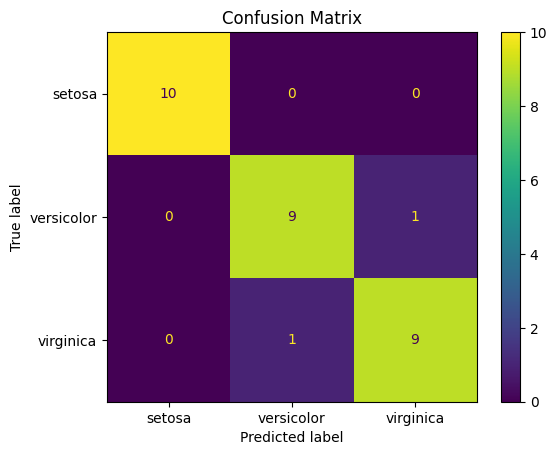


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [40]:
best_RF_clf = RandomForestClassifier(**best_params)
best_RF_clf.fit(X_train, y_train)

y_pred = RF_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

the D-Tree and Random Forest model show no difference in metrics, Reasoning:  

1. the data size is too small, hence the corner cases are too few, _just one in this case_.  
2. D-Tree was allowed to overfit and the RF was regularised by HPTing